In [1]:
# Scientific libraries
import numpy_html
import numpy as np
import scipy.stats as stats
import scipy.special as sf
import scipy.integrate as integrate
import scipy.interpolate as interpolate

# import Pandas

import pandas as pd
import astropy.io.fits as fits
import astropy.units as u
import astropy.constants as const

# Graphic libraries

import matplotlib.pyplot as plt
%matplotlib notebook
from jupyterthemes import jtplot
plt.style.use('mike_dark') 
jtplot.style(context='notebook', fscale=1, grid=False)

from glob import glob
import copy
import collections
#import warnings
#warnings.simplefilter('ignore')

import stan_utility

green = "#1DEBA6"
red = "#FF0059"
yellow = "#F6EF5B"


from pyipn import copy_template, Universe

In [2]:
#copy_template()

<IPython.core.display.Javascript object>


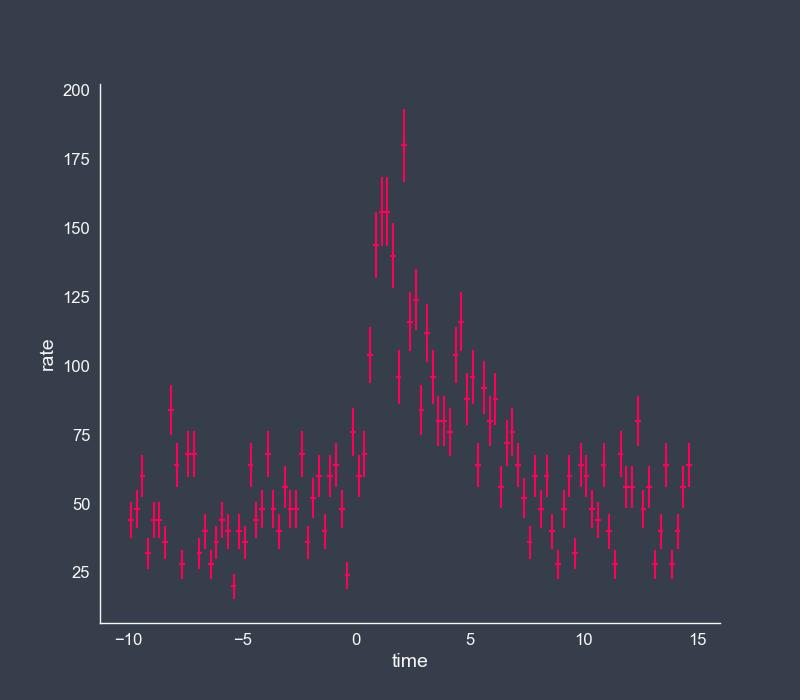

<IPython.core.display.Javascript object>


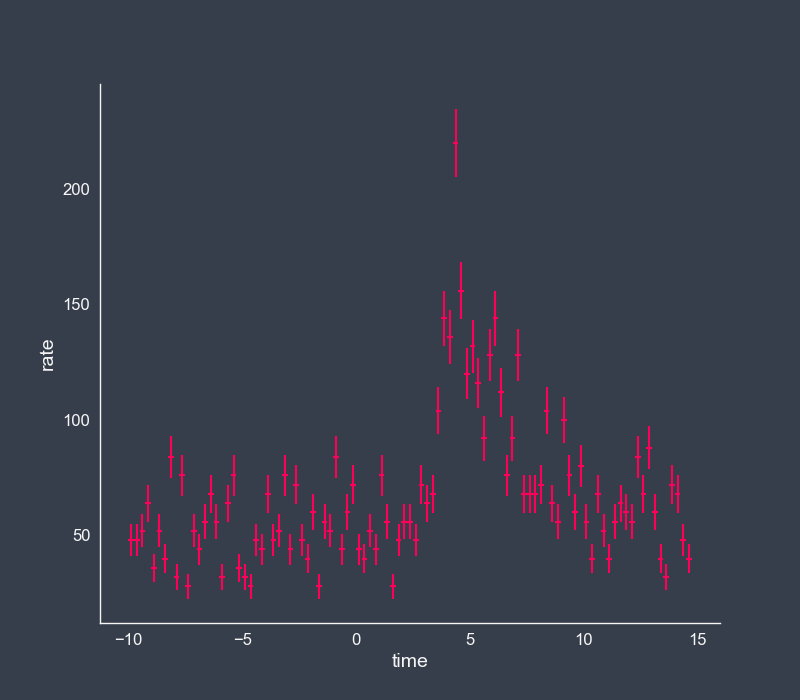

In [65]:
with plt.style.context('mike_dark'):

    uni = Universe.from_yaml('template_config.yaml')
    uni.explode_grb(tstart=-50,tstop=100)
    for det, lc in uni.light_curves.items():

        lc.display(-10,15,.25,color=red)



In [64]:
uni._time_differences

0.
2.96784228


In [66]:
lc = uni.light_curves['det1']
counts, times = lc.get_binned_light_curve(-10.4,15.4,.25)
mid = np.mean([times[:-1],times[1:]], axis=0)
width = times[1:] - times[:-1]




lc2 = uni.light_curves['det2']

counts2, times2 = lc2.get_binned_light_curve(-10,15,.25)
mid2 = np.mean([times2[:-1],times2[1:]], axis=0)
width2 = times2[1:] - times2[:-1]
k=50

N_model = 200

predict_time = np.linspace(-20,40,N_model)
omega=np.random.randn(k)

data = dict(N1=len(counts),
            time1=mid,
            counts1=counts.astype(int),
            exposure1=width,
            exposure2=width2,
            N2=len(counts2),
            time2=mid2,
            counts2=counts2.astype(int),
            k=k,
            bw=.2,
            omega=omega,
            N_model=N_model,
            predict_time=predict_time
           
           
           
           )

In [67]:
model = stan_utility.compile_model('rff.stan', model_name='rff')
#model = stan_utility.compile_model('gp_light_curve.stan', model_name='gplc')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL rff_db3e40bd7145d07c869d3e3e6ef0d22f NOW.


In [ ]:
fit = model.sampling(warmup=2000,iter=2500,data=data, chains=4, seed=1234,
                     control = dict(max_treedepth=15, adapt_delta=.9)
                    

                    )

<IPython.core.display.Javascript object>


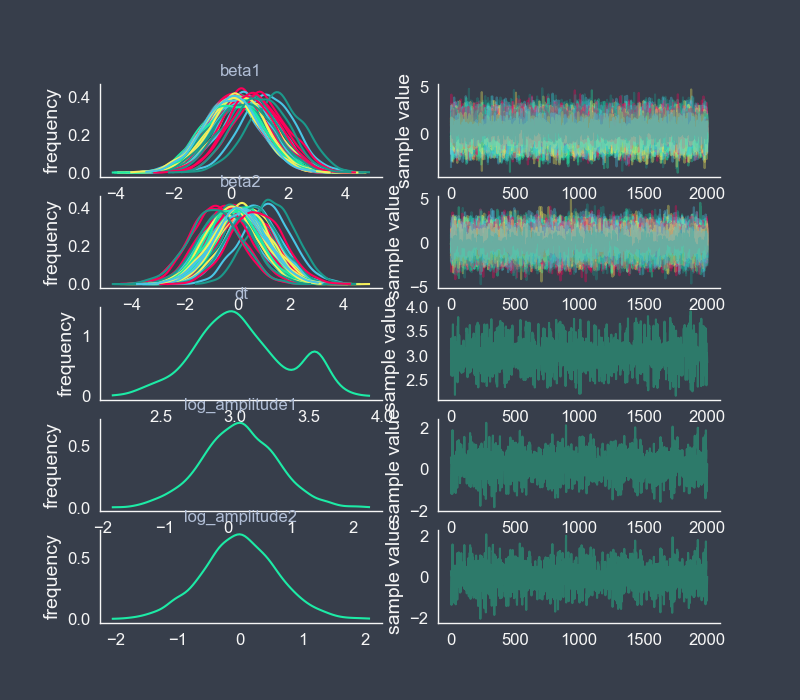

In [55]:
with plt.style.context('mike_dark'):
    fit.plot(['beta1','beta2',
              'dt',
              'log_amplitude1',
               'log_amplitude2'
             
             ]);

<IPython.core.display.Javascript object>


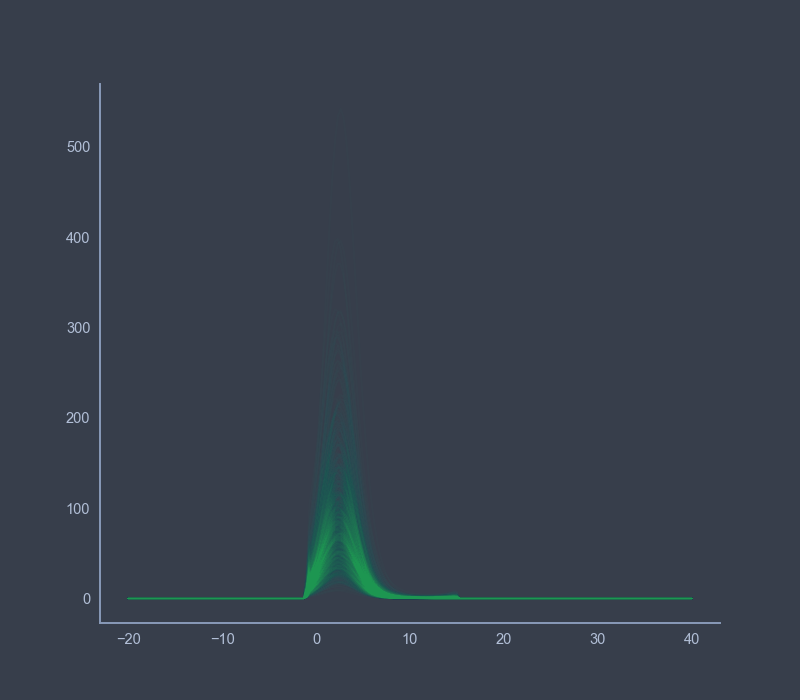

In [56]:
fig, ax = plt.subplots()

predict = fit.extract('predict')['predict']


for p in predict[::2]:

    ax.plot(predict_time,p, alpha=0.01, color=green )


<IPython.core.display.Javascript object>


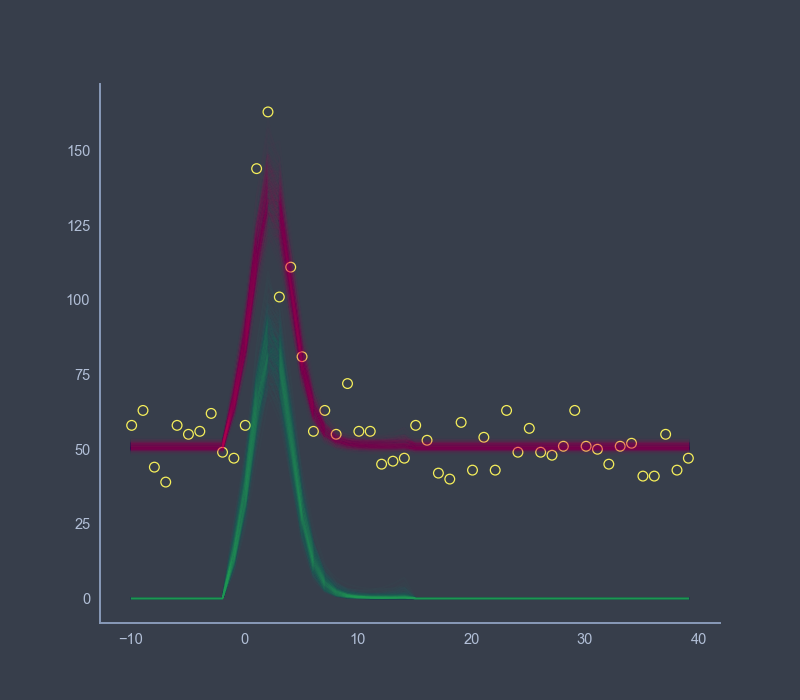

In [57]:
fig, ax = plt.subplots()

fhat = fit.extract("fhat1")["fhat1"]
bkg = fit.extract("bkg1")["bkg1"]

for y, b in zip(fhat[::10], bkg[::10]):

    ax.plot(mid, y, alpha=0.01, color=green)
    ax.plot(mid, y + b, alpha=0.01, color=red)
#    ax.plot(mid,[b]*len(mid), alpha=0.01, color="k")


ax.scatter(mid, counts, edgecolor=yellow, facecolor="none", lw=0.9)

<IPython.core.display.Javascript object>


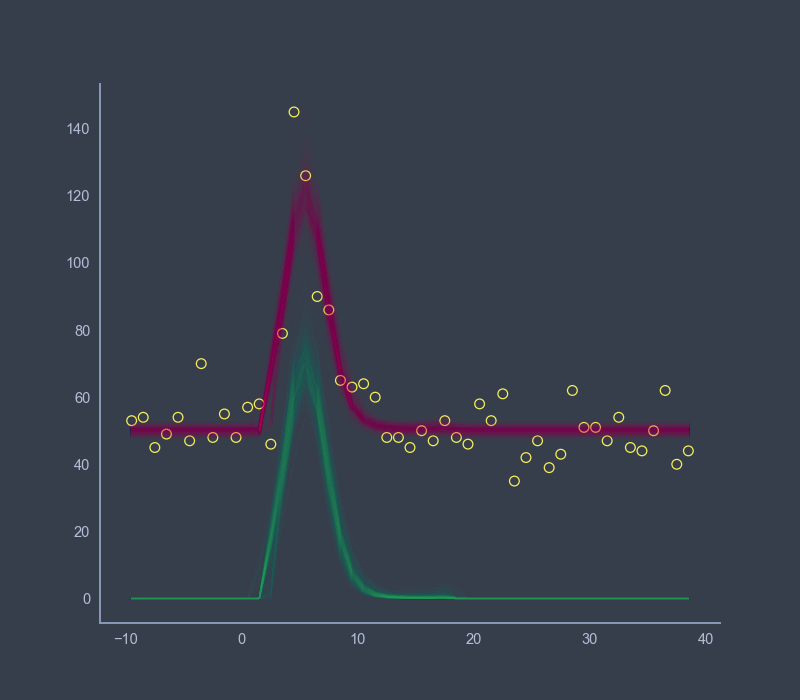

In [58]:
fig, ax = plt.subplots()

fhat = fit.extract('fhat2')['fhat2']
bkg = fit.extract('bkg2')['bkg2']

for y, b in zip(fhat[::10], bkg[::10]):

    ax.plot(mid2,y, alpha=0.01, color=green)
    ax.plot(mid2,y +b, alpha=0.01, color=red)
#    ax.plot(mid2,[b]*len(mid), alpha=0.01, color="k")


ax.scatter(mid2, counts2, edgecolor=yellow, facecolor='none',lw=.9)

<IPython.core.display.Javascript object>


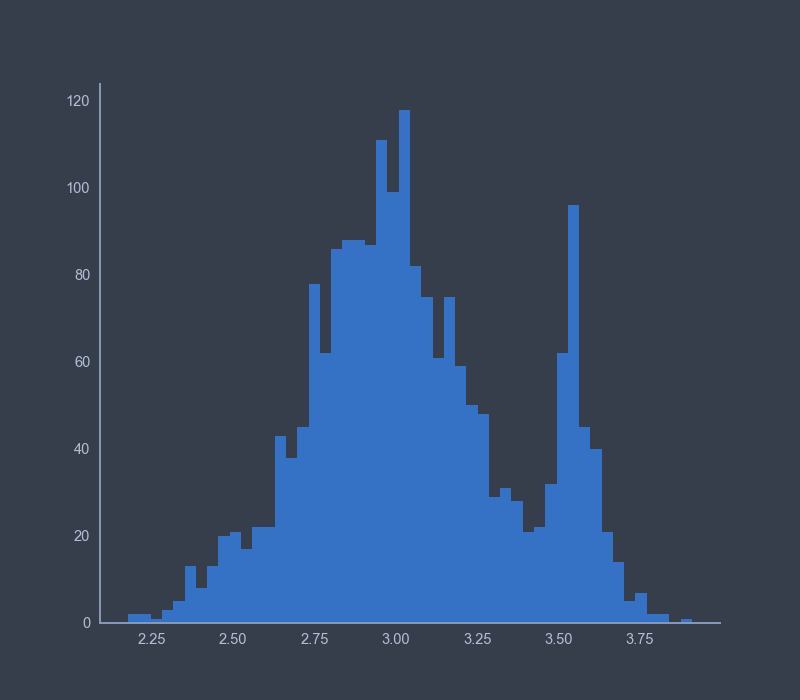

(array([  2.,   2.,   1.,   3.,   5.,  13.,   8.,  13.,  20.,  21.,  17.,
         22.,  22.,  43.,  38.,  45.,  78.,  62.,  86.,  88.,  88.,  87.,
        111.,  99., 118.,  82.,  75.,  61.,  75.,  59.,  50.,  48.,  29.,
         31.,  28.,  21.,  22.,  32.,  62.,  96.,  45.,  40.,  21.,  14.,
          5.,   7.,   2.,   2.,   0.,   1.]),
 array([2.17712935, 2.21179045, 2.24645155, 2.28111265, 2.31577375,
        2.35043486, 2.38509596, 2.41975706, 2.45441816, 2.48907927,
        2.52374037, 2.55840147, 2.59306257, 2.62772367, 2.66238478,
        2.69704588, 2.73170698, 2.76636808, 2.80102918, 2.83569029,
        2.87035139, 2.90501249, 2.93967359, 2.9743347 , 3.0089958 ,
        3.0436569 , 3.078318  , 3.1129791 , 3.14764021, 3.18230131,
        3.21696241, 3.25162351, 3.28628462, 3.32094572, 3.35560682,
        3.39026792, 3.42492902, 3.45959013, 3.49425123, 3.52891233,
        3.56357343, 3.59823454, 3.63289564, 3.66755674, 3.70221784,
        3.73687894, 3.77154005, 3.80620115, 3.

In [59]:
fig, ax = plt.subplots()

dt = fit.extract('dt')['dt']


ax.hist(dt,bins=50)

<IPython.core.display.Javascript object>


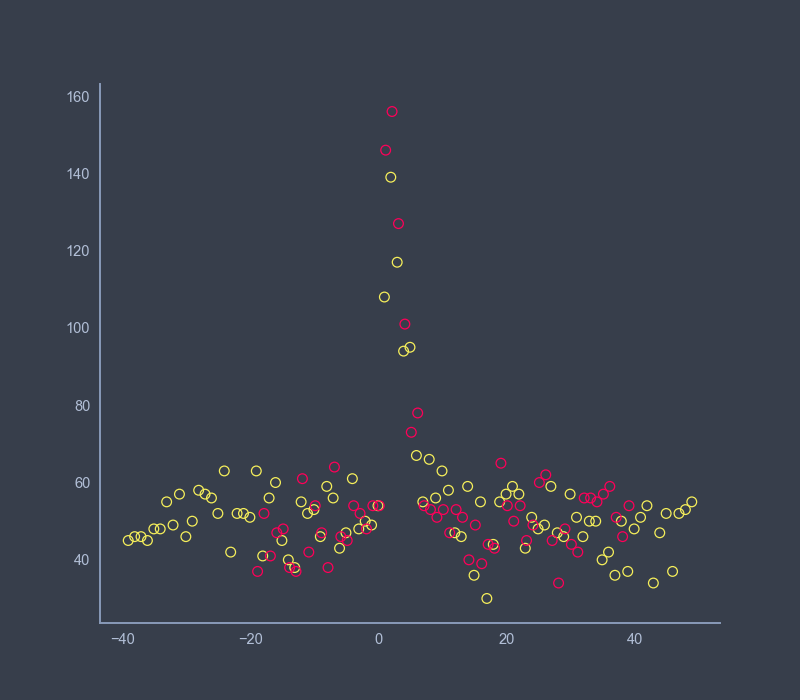

In [25]:
fig, ax = plt.subplots()

dt = 29.6


ax.scatter(mid2 -dt, counts2 , edgecolor=yellow, facecolor='none',lw=.9)
ax.scatter(mid, counts , edgecolor=red, facecolor='none',lw=.9)

<IPython.core.display.Javascript object>


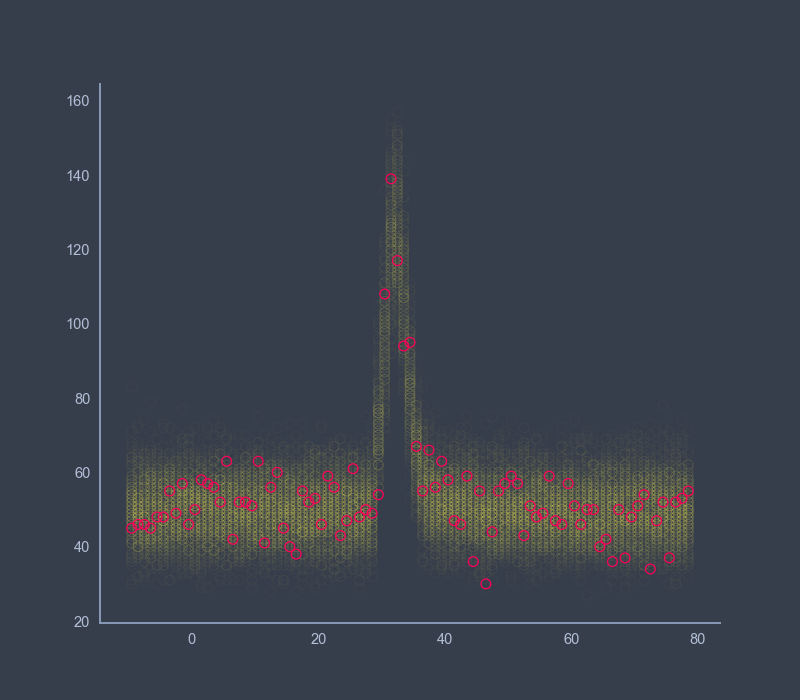

In [42]:
fig, ax = plt.subplots()

ppc2 = fit.extract('ppc2')['ppc2']


for p in ppc2[::10]:

    ax.scatter(mid2,p, alpha=0.025,  edgecolor=yellow, facecolor='none',lw=.9)
   
#    ax.plot(mid2,[b]*len(mid), alpha=0.01, color="k")


ax.scatter(mid2, counts2, edgecolor=red, facecolor='none',lw=.9)

<IPython.core.display.Javascript object>


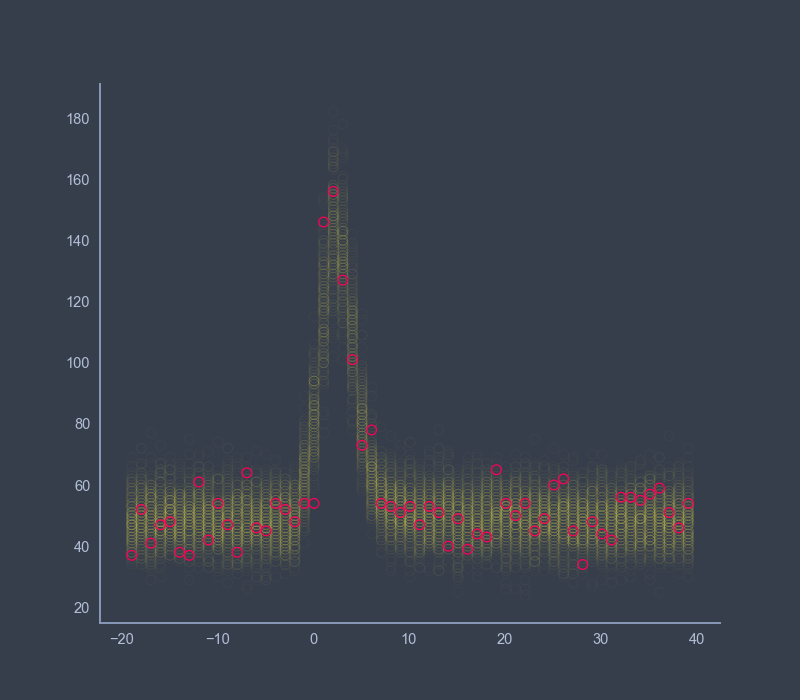

In [43]:
fig, ax = plt.subplots()

ppc1 = fit.extract('ppc1')['ppc1']


for p in ppc1[::10]:

    ax.scatter(mid,p, alpha=0.025,  edgecolor=yellow, facecolor='none',lw=.9)
   
#    ax.plot(mid2,[b]*len(mid), alpha=0.01, color="k")


ax.scatter(mid, counts, edgecolor=red, facecolor='none',lw=.9)